In [31]:
import pandas as pd

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
df_data = pd.read_csv("Data/model_formatted/model_mental_health_country.csv")
df_data.head()

User_ID  Age      Gender  Occupation    Country Mental_Health_Issue  \
0        1   36  Non-binary       Sales     Canada                  No   
1        2   34      Female   Education         UK                 Yes   
2        3   65  Non-binary       Sales        USA                 Yes   
3        4   34        Male       Other  Australia                  No   
4        5   22      Female  Healthcare     Canada                 Yes   

  Consultation_History Stress_Level  Sleep_Hours  Work_Hours  \
0                  Yes       Medium          7.1        46.0   
1                   No          Low          7.5        47.0   
2                   No          Low          8.4        58.0   
3                   No       Medium          9.8        30.0   
4                  Yes       Medium          4.9        62.0   

   Physical_Activity_Hours  Happiness score       GDP  Corruption  \
0                        5         7.235275  0.779596    0.511396   
1                        8         7.118125  0.756495    0.406988   
2                       10         6.917150  0.821891    0.501688   
3                        2         7.226450  0.784249    0.522721   
4                        5         7.235275  0.779596    0.511396   

   Healthy life expectancy  
0                 0.892108  
1                 0.859048  
2                 0.746160  
3                 0.895750  
4                 0.892108

In [35]:
df_data.columns

Index(['User_ID', 'Age', 'Gender', 'Occupation', 'Country',
       'Mental_Health_Issue', 'Consultation_History', 'Stress_Level',
       'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours',
       'Happiness score', 'GDP', 'Corruption', 'Healthy life expectancy'],
      dtype='object')

In [36]:
print(df_data['Gender'].unique().tolist())
print(df_data['Occupation'].unique().tolist())
print(df_data['Consultation_History'].unique().tolist())
print(df_data['Stress_Level'].unique().tolist())
print(df_data['Country'].unique().tolist())

['Non-binary', 'Female', 'Male', 'Prefer not to say']
['Sales', 'Education', 'Other', 'Healthcare', 'IT', 'Engineering', 'Finance']
['Yes', 'No']
['Medium', 'Low', 'High']
['Canada', 'UK', 'USA', 'Australia', 'India', 'Other', 'Germany']


In [47]:
df_data['Sleep_Hours'].describe()

count    1000.000000
mean        6.914538
std         1.618507
min         4.000000
25%         5.600000
50%         6.900000
75%         8.200000
max        10.000000
Name: Sleep_Hours, dtype: float64

In [48]:
df_data['Work_Hours'].describe()

count    1000.000000
mean       54.759615
std        14.553943
min        30.000000
25%        42.000000
50%        55.000000
75%        67.000000
max        80.000000
Name: Work_Hours, dtype: float64

In [49]:
df_data['Physical_Activity_Hours'].describe()

count    1000.00000
mean        5.09100
std         3.03973
min         0.00000
25%         3.00000
50%         5.00000
75%         8.00000
max        10.00000
Name: Physical_Activity_Hours, dtype: float64

### Data Preparation

In [50]:
X = df_data.drop(['User_ID','Country','Mental_Health_Issue'],axis=1)
y = df_data['Mental_Health_Issue']

In [51]:
categories = X.select_dtypes(include='object').columns
numerical = X.select_dtypes(exclude='object').columns

X[numerical] = X[numerical].astype('float')

print(categories)
print(numerical)

Index(['Gender', 'Occupation', 'Consultation_History', 'Stress_Level'], dtype='object')
Index(['Age', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours',
       'Happiness score', 'GDP', 'Corruption', 'Healthy life expectancy'],
      dtype='object')


In [52]:
# numerical_transformer = StandardScaler()

label_encoders = {}
for col in categories:
    if col in X.columns:
        label_encoders[col] = LabelEncoder()
        X[col] = label_encoders[col].fit_transform(X[col])

y[y == 'Yes'] = 1
y[y == 'No'] = 0
y = y.astype('int')

label_encoders

C:\Users\22845\AppData\Local\Temp\ipykernel_43916\2689936995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'Yes'] = 1
C:\Users\22845\AppData\Local\Temp\ipykernel_43916\2689936995.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'No'] = 0


{'Gender': LabelEncoder(),
 'Occupation': LabelEncoder(),
 'Consultation_History': LabelEncoder(),
 'Stress_Level': LabelEncoder()}

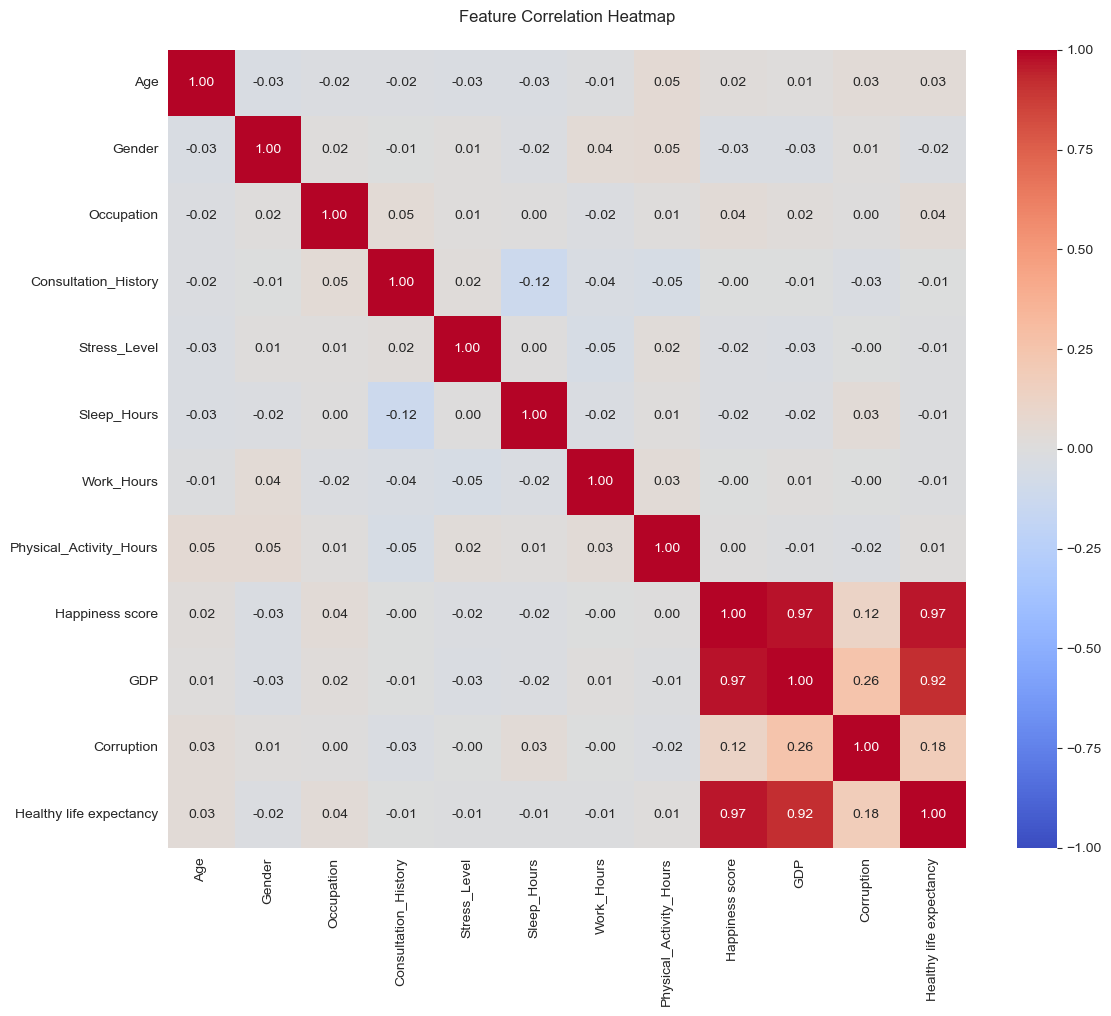

In [53]:
corr_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm',  
            vmin=-1, vmax=1,  
            center=0, 
            fmt='.2f', 
            square=True) 

plt.title('Feature Correlation Heatmap', pad=20)
plt.tight_layout()

plt.show()

In [54]:
# drop high correlated features
X = X.drop(['GDP','Healthy life expectancy'],axis=1)

### Feature Selection

In [55]:
X.columns

Index(['Age', 'Gender', 'Occupation', 'Consultation_History', 'Stress_Level',
       'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours',
       'Happiness score', 'Corruption'],
      dtype='object')

In [56]:
def find_optimal_n_features(X, y, max_features=None, cv=5):
    if max_features is None:
        max_features = X.shape[1]

    n_features_range = range(1, max_features + 1)
    cv_scores = []
    feature_sets = []

    for n in n_features_range:
        # Create a logistic regression estimator
        estimator = LogisticRegression(random_state=42)
        selector = RFE(estimator=estimator, n_features_to_select=n, step=1)
        
        # calculate cross-validation score
        scores = cross_val_score(
            estimator, 
            selector.fit_transform(X, y), 
            y, 
            cv=cv, 
            scoring='accuracy'
        )
        
        cv_scores.append(np.mean(scores))
        
        selected_features = X.columns[selector.support_].tolist()
        feature_sets.append(selected_features)
    
    # find optimal n_features
    optimal_n = n_features_range[np.argmax(cv_scores)]
    
    # plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(n_features_range, cv_scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-validation Accuracy')
    plt.title('Feature Selection: Accuracy vs Number of Features')
    plt.grid(True)
    plt.show()
    
    # print the results
    print("\nResults for each number of features:")
    for n, score, features in zip(n_features_range, cv_scores, feature_sets):
        print(f"\nFeatures: {n}")
        print(f"CV Accuracy: {score:.4f}")
        print("Selected features:", features)
    
    print(f"\nOptimal number of features: {optimal_n}")
    print(f"Best CV accuracy: {max(cv_scores):.4f}")
    print("Best feature set:", feature_sets[np.argmax(cv_scores)])
    
    return optimal_n, feature_sets[np.argmax(cv_scores)]


optimal_n_features, best_features = find_optimal_n_features(X, y)

E:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu


Results for each number of features:

Features: 1
CV Accuracy: 0.5810
Selected features: ['Consultation_History']

Features: 2
CV Accuracy: 0.5850
Selected features: ['Consultation_History', 'Stress_Level']

Features: 3
CV Accuracy: 0.5760
Selected features: ['Consultation_History', 'Stress_Level', 'Sleep_Hours']

Features: 4
CV Accuracy: 0.5730
Selected features: ['Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Corruption']

Features: 5
CV Accuracy: 0.5680
Selected features: ['Gender', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Corruption']

Features: 6
CV Accuracy: 0.5740
Selected features: ['Gender', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Happiness score', 'Corruption']

Features: 7
CV Accuracy: 0.5760
Selected features: ['Gender', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Physical_Activity_Hours', 'Happiness score', 'Corruption']

Features: 8
CV Accuracy: 0.5810
Selected features: ['Gender', 'Consultation_History', 'Stress_Level'

In [121]:
X.dtypes

Age                        float64
Gender                       int32
Occupation                   int32
Consultation_History         int32
Stress_Level                 int32
Sleep_Hours                float64
Work_Hours                 float64
Physical_Activity_Hours    float64
Happiness score            float64
Corruption                 float64
dtype: object

In [125]:
y.dtypes

dtype('int32')

In [122]:
X.head()

Age  Gender  Occupation  Consultation_History  Stress_Level  Sleep_Hours  \
0  36.0       2           6                     1             2          7.1   
1  34.0       0           0                     0             1          7.5   
2  65.0       2           6                     0             1          8.4   
3  34.0       1           5                     0             2          9.8   
4  22.0       0           3                     0             2          4.9   

   Work_Hours  Physical_Activity_Hours  Happiness score  Corruption  
0        46.0                      5.0         7.235275    0.511396  
1        47.0                      8.0         7.118125    0.406988  
2        58.0                     10.0         6.917150    0.501688  
3        30.0                      2.0         7.226450    0.522721  
4        62.0                      5.0         7.235275    0.511396

In [57]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# # Load dataset
# data = load_boston()
# X = pd.DataFrame(data.data, columns=data.feature_names)
# y = data.target

# Forward selection function
def forward_selection(X, y):
    selected_features = []
    remaining_features = list(X.columns)
    print(remaining_features)
    best_score = float('-inf')
    
    while remaining_features:
        scores = []
        for feature in remaining_features:
            # Temporarily add the feature to the selected set
            temp_features = selected_features + [feature]
            model = LogisticRegression()
            score = np.mean(cross_val_score(model, X[temp_features], y, cv=5, scoring='accuracy'))
            scores.append((score, feature))
            
            print(feature, score)
        
        # Select the feature with the best score
        scores.sort(reverse=True)
        if scores[0][0] > best_score:
            best_score, best_feature = scores[0]
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f"Selected feature: {best_feature}, R2 score: {best_score}")
        else:
            break  # Stop if no improvement
    
    return selected_features

# Run forward selection
selected_features = forward_selection(X, y)
print("Final selected features:", selected_features)

['Age', 'Gender', 'Occupation', 'Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours', 'Happiness score', 'Corruption']
Age 0.5679999999999998
Gender 0.5679999999999998
Occupation 0.5679999999999998
Consultation_History 0.5810000000000001
Stress_Level 0.54
Sleep_Hours 0.599
Work_Hours 0.569
Physical_Activity_Hours 0.5679999999999998
Happiness score 0.5679999999999998
Corruption 0.5679999999999998
Selected feature: Sleep_Hours, R2 score: 0.599
Age 0.6
Gender 0.583
Occupation 0.5879999999999999
Consultation_History 0.5810000000000001
Stress_Level 0.554
Work_Hours 0.596
Physical_Activity_Hours 0.599
Happiness score 0.598
Corruption 0.594
Selected feature: Age, R2 score: 0.6
Gender 0.585
Occupation 0.591
Consultation_History 0.5790000000000001
Stress_Level 0.5529999999999999
Work_Hours 0.591
Physical_Activity_Hours 0.5980000000000001
Happiness score 0.5979999999999999
Corruption 0.599
Final selected features: ['Sleep_Hours', 'Age']


In [83]:
def select_features_rfe(X, y, n_features=2):
    estimator = LogisticRegression(random_state=42)
    # n_features=optimal_n_features
    selector = RFE(estimator=estimator, n_features_to_select=n_features, step=1)
    selector = selector.fit(X, y)
    
    selected_features = X.columns[selector.support_].tolist()
    
    # 指定features
    selected_features = ['Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours','Happiness score']
    
    feature_ranking = pd.DataFrame({
        'Feature': X.columns,
        'Selected': selector.support_,
        'Rank': selector.ranking_
    }).sort_values('Rank')
    
    print("\nFeature Rankings:")
    print(feature_ranking)
    print("\nSelected features:", selected_features)
    
    X_selected = X[selected_features]
    
    return X_selected, selector, selected_features

# X_selected, selector, selected_features = select_features_rfe(X, y, optimal_n_features)
X_selected, selector, selected_features = select_features_rfe(X, y)


Feature Rankings:
                   Feature  Selected  Rank
3     Consultation_History      True     1
4             Stress_Level      True     1
5              Sleep_Hours     False     2
9               Corruption     False     3
1                   Gender     False     4
8          Happiness score     False     5
7  Physical_Activity_Hours     False     6
6               Work_Hours     False     7
2               Occupation     False     8
0                      Age     False     9

Selected features: ['Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours', 'Happiness score']


E:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

### Train Model

In [84]:
X_selected.columns

Index(['Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours',
       'Physical_Activity_Hours', 'Happiness score'],
      dtype='object')

In [98]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred))
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_test_pred))

    return model, scaler


model, scaler = train_model(X_selected, y)


Training Set Performance:
              precision    recall  f1-score   support

           0       0.51      0.35      0.41       384
           1       0.61      0.75      0.67       516

    accuracy                           0.58       900
   macro avg       0.56      0.55      0.54       900
weighted avg       0.57      0.58      0.56       900


Test Set Performance:
              precision    recall  f1-score   support

           0       0.61      0.35      0.45        48
           1       0.57      0.79      0.66        52

    accuracy                           0.58       100
   macro avg       0.59      0.57      0.55       100
weighted avg       0.59      0.58      0.56       100


In [99]:
# selected_features = ['Consultation_History', 'Stress_Level', 'Sleep_Hours', 'Work_Hours', 'Physical_Activity_Hours','Happiness score']

model.coef_

array([[ 0.30356728, -0.22456563, -0.22221708,  0.14176822, -0.09141123,
        -0.06130889]])

In [100]:
# save model
model_data = {
    'model': model,
    'scaler': scaler,
    'selector': selector,
    'label_encoders': label_encoders,
    'selected_features': selected_features
}
joblib.dump(model_data, 'mental_health_model_58.pkl')

['mental_health_model_58.pkl']

### Prediction

In [110]:

new_data_yes = {
    'Age': ['25-34'],
    'Gender': ['Male'],
    'Occupation': ['IT'],
    'Country': ['USA'],
    'Consultation_History': ['Yes'],
    'Stress_Level': ['High'],
    'Sleep_Hours': [5],
    'Work_Hours': [90],
    'Physical_Activity_Hours': [0],
    'Happiness score': [1.1],
    'GDP': [650],
    'Corruption': [25],
    'Healthy life expectancy': [30]
}

In [111]:

new_data_no = {
    'Age': ['25-34'],
    'Gender': ['Female'],
    'Occupation': ['Education'],
    'Country': ['Australia'],
    'Consultation_History': ['No'],
    'Stress_Level': ['Low'],
    'Sleep_Hours': [10],
    'Work_Hours': [30],
    'Physical_Activity_Hours': [10],
    'Happiness score': [9.0],
    'GDP': [650000],
    'Corruption': [25],
    'Healthy life expectancy': [70]
}

In [103]:
# get model data from file
model_data = joblib.load('mental_health_model_58.pkl')
model = model_data['model']
scaler = model_data['scaler']
selector = model_data['selector']
label_encoders = model_data['label_encoders']
selected_features = model_data['selected_features']

In [104]:
model_data['model'].coef_

array([[ 0.30356728, -0.22456563, -0.22221708,  0.14176822, -0.09141123,
        -0.06130889]])

In [105]:
def predict_health_score(input_data, model, scaler, selector, label_encoders, selected_features):
    if not isinstance(input_data, pd.DataFrame):
        input_data = pd.DataFrame([input_data])

    input_processed = input_data.copy()
    for col, encoder in label_encoders.items():
        if col in input_processed.columns:
            input_processed[col] = encoder.transform(input_processed[col])

    input_processed = input_processed[selected_features]

    input_scaled = scaler.transform(input_processed)
    
    prediction_label = model.predict(input_scaled)
    prediction_value = model.predict_proba(input_scaled)
    return prediction_label,prediction_value
    
    # prediction = model.predict_proba(input_scaled)
    # health_score = prediction[:, 1] * 100
    return health_score


In [112]:

new_data_df = pd.DataFrame(new_data_no)
prediction_label,prediction_value = predict_health_score(
    new_data_df,
    model,
    scaler,
    selector,
    label_encoders,
    selected_features
)
#print(f"\nPredicted mental health score: {health_score[0]:.2f}%")
print(prediction_label,prediction_value)

[0] [[0.72074691 0.27925309]]


In [113]:

new_data_df = pd.DataFrame(new_data_yes)
prediction_label,prediction_value = predict_health_score(
    new_data_df,
    model,
    scaler,
    selector,
    label_encoders,
    selected_features
)
#print(f"\nPredicted mental health score: {health_score[0]:.2f}%")
print(prediction_label,prediction_value)

[1] [[0.12862427 0.87137573]]
